In [26]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def make_env():
    """
    Crea e restituisce l'ambiente Ant-v5 dalla libreria Gymnasium.

    Questa funzione istanzia l'ambiente "Ant-v5", uno degli ambienti recenti e ben supportati
    in Gymnasium. I parametri usati sono:
    - reset_noise_scale (0.1): determina la scala del rumore quando l'ambiente viene resettato.
    - render_mode ('None'): indica che non verrà effettuato il rendering durante l'esecuzione.

    Ritorna:
        gym.Env: l'ambiente Ant-v5 inizializzato.
    """
    
    # Ant-v5 è l’ambiente più recente in Gymnasium.
    return gym.make("Ant-v5", 
                    reset_noise_scale=0.2282706739101626, # scala del rumore quando l'ambiente viene resettato 
                    forward_reward_weight=0.09314040045482441, # peso del reward per il movimento in avanti
                    ctrl_cost_weight=0.028140178122103423, # peso del reward per il controllo
                    healthy_reward =0.9926479631637423, # reward per la salute
                    render_mode='None')

In [28]:
# 1. Creiamo un ambiente vettorializzato (Vectorized Environment)
# Utilizziamo DummyVecEnv per gestire più istanze dell'ambiente come se fossero una singola entità.
# Qui passiamo la funzione make_env (definita in un'altra cella) che crea l'ambiente "Ant-v5".
env = DummyVecEnv([make_env])  

# 2. Normalizziamo osservazioni (obs) e ricompense (reward)
# VecNormalize scala le osservazioni e le ricompense per stabilizzare l'allenamento.
# Parametri:
#   norm_obs=True   -> Abilita la normalizzazione delle osservazioni.
#   norm_reward=True -> Abilita la normalizzazione delle ricompense.
#   clip_obs=10.     -> Limita i valori normalizzati dell'osservazione a un range [-10, 10] per evitare estremi.
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

/Users/fabiodigregorio/Desktop/campus bio iscrizione/ Magistrale/Merone/RL/Reinforcement_Learning_Ant_MuJoCu/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:734: UserWarning: WARN: The environment is being initialised with render_mode='None' that is not in the possible render_modes (['human', 'rgb_array', 'depth_array']).
  logger.warn(


In [29]:
# 3. Definiamo il modello RL (PPO) con spiegazioni dettagliate per ciascun parametro

model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=0.0003,  # Ridotto per evitare aggiornamenti instabili
    n_steps=2048,  # Mantenuto per bilanciare stabilità ed efficienza
    batch_size=64,  # Manteniamo lo stesso batch size
    n_epochs=10,  # Ridotto per evitare overfitting
    gamma=0.99,  # Aumentato per migliorare l'importanza delle ricompense future
    gae_lambda=0.95,  # Manteniamo questo valore
    clip_range=0.2,  # Aumentato per dare più libertà alla policy
    ent_coef=0.01,  # Aggiunto per incentivare una leggera esplorazione
    vf_coef=0.5,  # Aggiunto per dare più peso alla funzione di valore
    max_grad_norm=0.5,  # Aggiunto per evitare gradient explosion
    verbose=1,
    tensorboard_log="./ppo_Ant_tensorboard/",
    device='mps'
)

Using mps device


/Users/fabiodigregorio/Desktop/campus bio iscrizione/ Magistrale/Merone/RL/Reinforcement_Learning_Ant_MuJoCu/venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [30]:
# 4. Alleniamo il modello
# Il parametro total_timesteps indica il numero totale di iterazioni (o passi)
# che il modello eseguirà durante l'allenamento. Ogni timestep rappresenta un'interazione
# con l'ambiente in cui il modello esegue un'azione e riceve un feedback, che viene poi
# usato per aggiornare la sua politica interna.
total_timesteps = 5000000  # Puoi aumentare questo valore per permettere al modello di acquisire più esperienza.
model.learn(total_timesteps=total_timesteps)

Logging to ./ppo_Ant_tensorboard/PPO_4


-----------------------------
| time/              |      |
|    fps             | 360  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018420346 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | -1.17       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.114      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0349     |
|    std                  | 1           |
|    value_loss           | 0.49        |
----------------------------------

In [31]:
#5. Salviamo il modello
model.save("ppo_Ant_model")
env.save("vecnormalize_Ant.pkl")  # salviamo anche i parametri di normalizzazione

In [32]:
def evaluate_policy(env, policy, episodes=50):
    """
    Valuta una policy addestrata su un ambiente dato.

    Parametri:
    - env: L'ambiente di simulazione.
    - policy: La policy addestrata da valutare.
    - episodes: Numero di episodi da eseguire per la valutazione.

    Ritorna:
    - La ricompensa media e la deviazione standard delle ricompense ottenute.
    """
    total_rewards = []
    for _ in range(episodes):
        obs = env.reset()  # Reset dell'ambiente per iniziare un nuovo episodio
        done = False
        total_reward = 0
        while not done:
            action, _ = policy.predict(obs)  # Predice l'azione da eseguire
            obs, reward, done, _ = env.step(action)  # Esegue l'azione e ottiene il feedback dall'ambiente
            total_reward += reward  # Accumula la ricompensa ottenuta
        total_rewards.append(total_reward)  # Aggiunge la ricompensa totale dell'episodio alla lista
    return np.mean(total_rewards), np.std(total_rewards)  # Calcola e ritorna la media e la deviazione standard delle ricompense


def evaluate_random_policy(env, episodes=5000):
    """
    Valuta una policy casuale su un ambiente dato.

    Parametri:
    - env: L'ambiente di simulazione.
    - episodes: Numero di episodi da eseguire per la valutazione.

    Ritorna:
    - La ricompensa media e la deviazione standard delle ricompense ottenute.
    """
    total_rewards = []
    for _ in range(episodes):
        obs = env.reset()  # Reset dell'ambiente per iniziare un nuovo episodio
        done = False
        total_reward = 0
        while not done:
            action = env.action_space.sample()  # Genera un'azione casuale
            obs, reward, done, _ = env.step(np.array([action]))  # Esegue l'azione e ottiene il feedback dall'ambiente
            total_reward += reward  # Accumula la ricompensa ottenuta
        total_rewards.append(total_reward)  # Aggiunge la ricompensa totale dell'episodio alla lista
    return np.mean(total_rewards), np.std(total_rewards)  # Calcola e ritorna la media e la deviazione standard delle ricompense

Trained Policy: Mean Reward: 5.4697794914245605, Std: 9.441436767578125
Random Policy: Mean Reward: 7.851289749145508, Std: 10.90255069732666


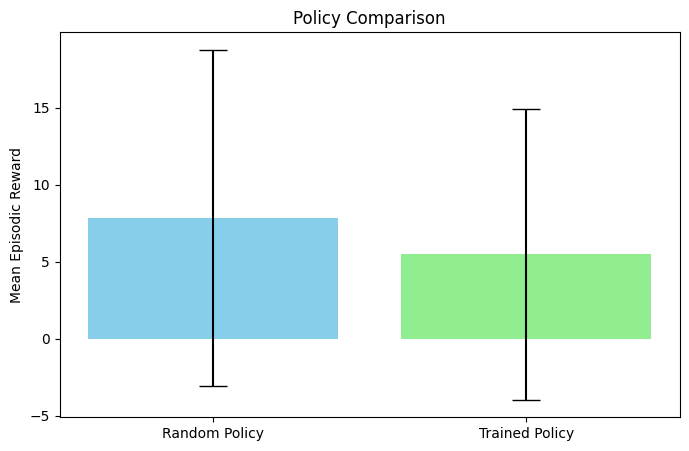

In [33]:
# Valutazione dopo l'addestramento
mean_reward_trained, std_reward_trained = evaluate_policy(env, model)  # Valuta la policy addestrata
mean_reward_random, std_reward_random = evaluate_random_policy(env)  # Valuta la policy casuale

# Stampa dei risultati
print(f"Trained Policy: Mean Reward: {mean_reward_trained}, Std: {std_reward_trained}")
print(f"Random Policy: Mean Reward: {mean_reward_random}, Std: {std_reward_random}")

# Creazione del grafico di confronto
labels = ['Random Policy', 'Trained Policy']
means = [mean_reward_random, mean_reward_trained]
stds = [std_reward_random, std_reward_trained]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, yerr=stds, capsize=10, color=['skyblue', 'lightgreen'])
plt.ylabel('Mean Episodic Reward')
plt.title('Policy Comparison')
plt.show()